In [ ]:
from nbdev import *
%nbdev_default_export b1259
%load_ext autoreload
%autoreload 2
!date

Cells will be exported to light_curves.b1259,
unless a different module is specified after an export flag: `%nbdev_export special.module`
Sun Apr 25 04:59:00 PDT 2021


# B1259-63 Analysis
> Create a B1259-63 (aka PSR J1302-6350) light curve using Bayesian Blocks  

* [HESS high-energy results](https://arxiv.org/pdf/astro-ph/0506280.pdf)

* [Previouis *fermi* paper](https://arxiv.org/pdf/1912.05868.pdf)

In [ ]:
%nbdev_export
import numpy as np
import matplotlib.pyplot as plt
from light_curves.tools import *
from wtlike.config import *
from wtlike.bayesian import *
from wtlike.lightcurve import * 
from utilities.ipynb_docgen import *

In [ ]:
%nbdev_export

class B1259Periastron(BayesianBlockAnalysis):
    
    tp, period = 55544.694, 1236.7243
    
    def __init__(self, config, bins=None, bin_key=None, clear=None):
        source = PointSource('PSR_B1259-63')
        super().__init__(config, source, bins=bins, clear=clear)
        self.partition( key = bin_key, clear=clear)
        
        self.mjd_dates = [self.tp+n*self.period for n in range(4)]
        
    def date_info(self):
        return pd.DataFrame([dict(MJD=round(d,3), UTC=UTC(d)) for d in self.mjd_dates ])
    
    def full_plot(self, fignum=2):
        fig, ax2 = plt.subplots(1,1, sharex=True, figsize=(20,4), num=fignum)
        self.plot( ax = ax2, yscale='log')
        ax2.text(0.05, 0.85, self.source.name,  transform=ax2.transAxes);
        ax2.set_xlabel('MJD', fontsize=20)
        return fig
    
    def stacked_plots(self, fignum=3, ylim=(2,200), ts_min=4):
 
        tp, p =self.tp, self.period
        fig, axx = plt.subplots(4,1, sharex=True, sharey=True, figsize=(12,12), num=fignum)
        plt.subplots_adjust(hspace=0.)
        for i, ax in enumerate(axx.flatten()):
            self.plot( ax=ax, tzero=tp+i*p, xlim=(-60,150), ylim=ylim, ts_min=ts_min,
                     colors=('red', 'bisque', 'blue'),
                     fmt='o', yscale='log', xlabel='',ylabel='', )
            ax.text(0.02, 0.85, UTC(tp+i*p)[:4], transform=ax.transAxes)
            ax.axvline(0, color='grey', ls=':')
        axx[-1].set_xlabel('days about periastron', fontsize=20)
        fig.text(0.04, 0.5, 'Relative Flux', va='center', rotation='vertical', fontsize=20)
        fig.width=600
        return fig

In [ ]:
%nbdev_collapse_input

config = Config(data_folder='/home/burnett/weekly', verbose=1)
bba = B1259Periastron(config)

photons and exposure for PSR_B1259-63: Saving to cache with key "PSR_B1259-63_weekly_data"
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/PSR_B1259-63_weights.pkl
	Found: P88Y3278 at (304.20, -0.99)
	Applyng weights: 87062 / 4064359 photon pixels are outside weight region
	923135 weights set to NaN
Time bins: 46

In [ ]:
%nbdev_collapse_input
def B1259( expect=1, bins=None, clear=False):
    r"""
    ## Fit to all data

    {date}
    
    Create a `BayesianBlockAnalysis` object with all the data
    
    {outp}
 
    Combine the likelihoods for all the data, check the fit. 
    Normalization should be very close to 1.0, a check on the weights.
    {fig1}
    
    Note that the "significant count factor", $\sigma_{{flux}} \times \sqrt{{N}}$, is {sig_cnt_factor:.0f}.
 
    ## The full daily-interval light curve, showing the BB partitions
    {fig2}
    
    ## Expand about each periastron
 
    #### Periastron dates

    Assuming {period}-day orbital period, the MJD and UTC values are:
    
    {utc}
 
    Expand the above about those dates

    {fig3}
    
    ## Recent detail 
    {fig4}
    
    ### Output Table
    
    {df_text}
    
    Download it: {link_to_lcfile}.
    """
    global bba #  make availlable for follow-up cells

    assert config.valid, f"Invalid configuration {config}"
 
    pd.set_option('display.precision', 3)#, 'display.colheader_justify','left')
    plt.rc('font', size=14)
    
    with capture_print('Output from analysis: create cells, fit each, run BB partition, fit partitions.') as outp:
        if bba is None:
            bba = B1259Periastron(config,  bins=bins, clear=clear)
 
        else:
            print('(already done)')
    lc = bba.lc_df
    bb_lc = bba.bb_fit
    period  = bba.period

    # Fig 1 -- fit to combined data
    
    lka = bba.all_data_likelihood()
    fig1,ax = plt.subplots(figsize=(4,2))
    lka.plot(ax=ax, xlim=(0.5, 1.5) )
    fi = lka.fit_info(); 
    sig_cnt_factor =  fi['sig_flux']*np.sqrt(fi['counts'])
    
    df = fit_table(bb_lc, expect=expect)
    df_text = monospace(str(df), 'BB fit table', open=True)

    # fig 2: full light curbe
    plt.rc('font', size=16)
    fig2 = bba.full_plot(2)
    fig2.width=600
    
    # fig 3 -- stack light curves
    utc = monospace(str(bba.date_info())) 
    fig3 = bba.stacked_plots(3)
    fig3.width=600
    
    # fig 4 -- recent detail
    fig4, ax=plt.subplots(figsize=(8,2.5))
    bba.plot(ax=ax,yscale='log',colors=('red', 'lightgrey', 'blue'),
             tzero=bba.mjd_dates[-1], xlim=(35, 75 ), ylim=(2,200));
    ax.set(xlabel='Days after 2021 Periastron');
    fig4.width=400
    
    # table of BB fits
    df = fit_table(bb_lc, expect=expect)
    df_text = monospace(str(df), 'fits to blocks.', open=False)
        
    ### Save the BB intervals
    lc_out = bb_lc.copy()

    lc_out.loc[:,'flux'] = bb_lc.fit.apply(lambda fit: round(fit.flux,3))
    errors = bb_lc.fit.apply(lambda fit: np.array(fit.errors).round(3)).values
    elow, ehigh = [[x[i] for x in errors] for i in range(2)]
    lc_out['low']=elow
    lc_out['high']=ehigh
    lc_display = lc_out['t tw n flux low high'.split()]
    
    lc_file = 'B1259_lc.csv'
    link_to_lcfile = create_file(lc_display.to_csv, lc_file)
    
    return locals()
%time nbdoc(B1259, clear=False)

## Fit to all data

2021-04-25 05:06

Create a `BayesianBlockAnalysis` object with all the data

<details  class="nbdoc-description" >  <summary> Output from analysis: create cells, fit each, run BB partition, fit partitions. </summary>  <div style="margin-left: 5%"><pre>(already done)<br></pre></div> </details>

Combine the likelihoods for all the data, check the fit. 
Normalization should be very close to 1.0, a check on the weights.
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/B1259_fig_01.png" title="images/B1259_fig_01.png">    <img src="images/B1259_fig_01.png" alt="Figure 1 at images/B1259_fig_01.png" >   </a> </figure>
</div>


Note that the "significant count factor", $\sigma_{flux} \times \sqrt{N}$, is 266.

## The full daily-interval light curve, showing the BB partitions
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/B1259_fig_02.png" title="images/B1259_fig_02.png">    <img src="images/B1259_fig_02.png" alt="Figure 2 at images/B1259_fig_02.png" width=600>   </a> </figure>
</div>


## Expand about each periastron

#### Periastron dates

Assuming 1236.7243-day orbital period, the MJD and UTC values are:

<div style="margin-left: 5%"><pre>         MJD               UTC<br>0  55544.694  2010-12-14 16:39<br>1  56781.418  2014-05-04 10:02<br>2  58018.143  2017-09-22 03:25<br>3  59254.867  2021-02-09 20:48</pre></div>

Expand the above about those dates

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 3">  <a href="images/B1259_fig_03.png" title="images/B1259_fig_03.png">    <img src="images/B1259_fig_03.png" alt="Figure 3 at images/B1259_fig_03.png" width=600>   </a> </figure>
</div>


## Recent detail 
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 4">  <a href="images/B1259_fig_04.png" title="images/B1259_fig_04.png">    <img src="images/B1259_fig_04.png" alt="Figure 4 at images/B1259_fig_04.png" width=400>   </a> </figure>
</div>


### Output Table

<details  class="nbdoc-description" >  <summary> fits to blocks. </summary>  <div style="margin-left: 5%"><pre>          t      tw       n     flux             errors  sigma_dev    limit<br>0   55102.5   828.0  530570    0.000         (0, 0.028)       -5.5    0.171<br>1   55539.5    35.0   21588    7.420    (-1.948, 1.998)        3.5   10.786<br>2   55560.5     7.0    7437   23.955    (-3.975, 4.006)        5.9   30.592<br>3   55569.0    10.0   11610    0.000         (0, 2.117)        0.4    4.796<br>4   55576.5     5.0    4275   48.408    (-5.932, 5.992)        8.3   58.358<br>5   55580.5     3.0    2584  109.998   (-9.902, 10.032)       11.9  126.702<br>6   55590.0    16.0    9724   58.521    (-4.164, 4.192)       14.5   65.461<br>7   55606.5    17.0   11039   30.596    (-3.415, 3.437)        8.9   36.282<br>8   56190.5  1100.0  757398    0.000         (0, 0.033)       -5.0    0.197<br>9   56788.0    44.0   34389    5.365    (-1.522, 1.554)        3.0    7.969<br>10  56813.5     7.0    9046   26.962    (-3.653, 3.679)        7.3   33.053<br>11  56819.0     4.0    5368   86.051    (-6.098, 6.154)       14.9   96.260<br>12  56826.0    10.0   10429   39.057    (-3.572, 3.596)       11.0   45.007<br>13  56831.5     1.0     746  164.644  (-20.649, 21.159)        8.9  200.244<br>14  56835.5     7.0    6269   54.396    (-4.969, 5.012)       11.2   62.704<br>15  56843.0     8.0    7943   11.060    (-3.408, 3.528)        3.2   17.054<br>16  56850.5     7.0    4272   58.684    (-6.245, 6.309)        9.7   69.161<br>17  57431.5  1148.0  779911    0.000         (0, 0.039)       -4.6    0.231<br>18  58034.0    50.0   32481   11.063    (-1.652, 1.658)        6.2   13.800<br>19  58059.5     1.0     988  210.762  (-20.182, 20.615)       11.8  245.344<br>20  58065.0    10.0   10606   24.515    (-3.316, 3.338)        7.3   30.038<br>21  58072.5     5.0    4039   60.638    (-6.453, 6.521)        9.7   71.469<br>22  58076.0     2.0    1589  186.122  (-14.802, 15.052)       14.0  211.268<br>23  58078.0     2.0    1302   81.676  (-12.209, 12.436)        7.1  102.486<br>24  58083.5     9.0    5049   31.771    (-4.926, 4.973)        6.5   40.022<br>25  58088.5     1.0     716  193.159  (-22.293, 22.855)        9.7  231.632<br>26  58091.0     4.0    2180   32.077    (-7.188, 7.592)        5.0   45.212<br>27  58656.5  1025.0  782536    0.000         (0, 0.041)       -4.4    0.247<br>28  59264.5    89.0   72332    5.029     (-1.045, 1.06)        4.0    6.797<br>29  59313.0     8.0    4503   28.252    (-5.056, 5.106)        5.6   36.729<br>30  59319.0     4.0    2722   75.888    (-8.216, 8.321)        9.7   89.738<br>31  59323.5     5.0    2684   18.656    (-5.779, 6.116)        3.5   29.256</pre></div> </details>

Download it: [B1259_lc.csv](images/B1259_lc.csv).


CPU times: user 10.7 s, sys: 39.1 ms, total: 10.7 s
Wall time: 10.8 s


## Questions for Discussion, with 2/28 Scargle comments

#### How do I interpret the apparent abrupt transitions? 
>Think of BB as the best step-function representation
of the data.  It does not mean that the discontinuities 
are claimed to be real -- the underlying light curve
is most likely continuous and smooth at some level.  
BB is just saying that there is a statistically significant
change from one block to the next.

Compare with a [flare from 3C 279](https://tburnett.github.io/wtlike/bayesian.html#bb_overplot), which has measurements rather than limits for each day and the time scale is in the day range. 

#### Is the day interval appropriate? 
>BB can always benefit from finer sampling, so if you
have data on shorter intervals (or even photon data)
you can get more information out ... e.g. a better 
determination of the time of "transitions" (see above).



#### I know that there is a ~4% systematic for the individual daily measurements, seen in the Geminga data. Does this matter?
>Systematic errors are a problem ... BB is not magic here.

## My observations, plans

There are two related questions here. 
1. what is the actual behavior of B1259, besides the obvious flares? Can we characterize each periastron to detect changes? Kent Wood is very interested in this.
2. How well does BB work, when applied to daily likelihoods, many of which are just limits, but do contain information? This is a question that Jeff Scargle had never considered before, but is quite interested in.


#### Run Simulations

I'll use the [wtlike simulation capability](https://tburnett.github.io/wtlike/simulation) to test the sensitivity to various light curves, when daily fits are all or mostly limits.

#### Add Systematics to Likelihood
The presence of a systematic error in the exposure--I've measured 4% with Geminga, slightly invalidates the likelihood. A fix is to widen it, which I can easily do using the [wtlike Poisson representation](https://tburnett.github.io/wtlike/poisson#Poisson). 

# Comparison with Tyrel's gtlike results

In [ ]:
%nbdev_collapse_input
remote_file = '/nfs/farm/g/glast/u/tyrelj/forToby/FluxLC_output_PSRB1259.fits'
local_copy = '/home/burnett/fromTyrel/FluxLC_output_PSRB1259.fits'
from astropy.io import fits
hdus= fits.open(local_copy); 

tdata = hdus[1].data

flux_factor = 4.28e7 # derived before, so apply here
tdf = pd.DataFrame(dict(t=MJD((tdata.Start+tdata.Stop)/2).round(1),
                        TS = tdata.TS.astype(float).round(1),
                        flux = (tdata.flux.astype(float)*flux_factor).round(1),
                        flux_error = (tdata.flux_error.astype(float)*flux_factor).round(1),
                        limit = (tdata.UpperLimit.astype(float)*flux_factor).round(1),
                       )
                    ); 
tdf.describe(percentiles=[])

,t,TS,flux,flux_error,limit
count,226.000,226.000,226.000,226.000,2.260e+02
mean,59206.000,1.169,5.649,5.964,-1.894e+05
std,65.386,3.493,10.135,6.604,2.847e+06
min,59093.500,-0.000,0.000,0.000,-4.280e+07
50%,59206.000,-0.000,0.000,2.250,2.315e+01
max,59318.600,34.300,62.300,27.000,1.144e+02


#### Get my results for these dates

In [ ]:
%nbdev_collapse_input
lc=bba.lc; 
mdf = lc.dataframe.query('59319>t>59093').copy()
mdf.loc[:,'ts']= mdf.fit.apply(lambda x: x.ts)
mdf.loc[:,'flux']=mdf.fit.apply(lambda x: round(x.flux,1) )
mdf.loc[:,'errors']= mdf.fit.apply(lambda x: (np.array(x.errors)-x.flux).round(1))
mdf.loc[:,'limit']= mdf.fit.apply(lambda x: x.limit.round(1))
mdf['t ts flux errors limit'.split()].describe(percentiles=[])

,t,ts,flux,limit
count,226.000,226.000,226.000,226.000
mean,59206.000,1.283,7.235,28.606
std,65.385,3.345,11.383,14.383
min,59093.500,0.000,0.000,11.500
50%,59206.000,0.032,1.750,25.300
max,59318.500,29.561,71.800,101.400


### Use the last one, at 59318.5, +63, to make tentative normalization

Compare point at 59318.5: TS: me 21.6, Tyrel 34.3
flux ratio check: 9.991e-01


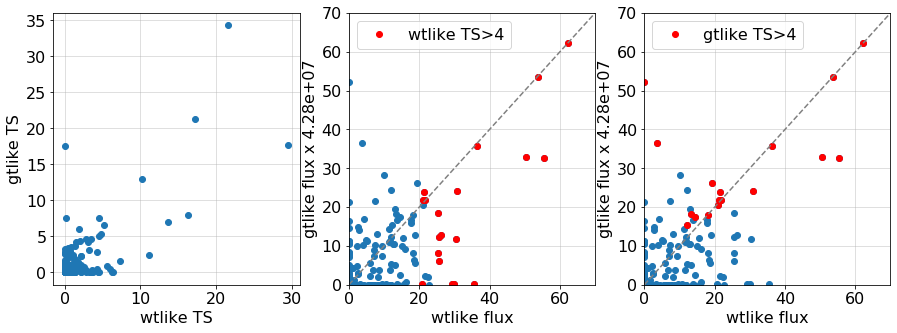

In [ ]:
%nbdev_collapse_input
f = mdf.iloc[-1].fit
print(f'Compare point at {mdf.iloc[-1].t}: TS: me {f.ts:.1f}, Tyrel {tdf.iloc[-1].TS:.1f}')
a,b = f.flux, tdf.iloc[-1].flux; a,b, 
print(f'flux ratio check: {a/b:.3e}')

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(mdf.ts, tdf.TS, 'o');
ax1.set(xlabel='wtlike TS', ylabel='gtlike TS')
ax1.grid(alpha=0.5)
mtscut= (mdf.ts>4).values
ax2.plot(mdf.flux, tdf.flux, 'o');
ax2.plot(mdf.flux[mtscut], tdf[mtscut].flux, 'or', label='wtlike TS>4');
ax2.plot([0,70], [0,70], '--', color='grey');
ax2.set(xlabel='wtlike flux', ylabel=f'gtlike flux x {flux_factor:.2e}', xlim=(0,70), ylim=(0,70))
ax2.legend();ax2.grid(alpha=0.5);

ttscut=(tdf.TS>4).values
ax3.plot(mdf.flux, tdf.flux, 'o');
ax3.plot(mdf.flux[ttscut], tdf[ttscut].flux, 'or', label='gtlike TS>4');
ax3.plot([0,70], [0,70], '--', color='grey');
ax3.legend()
ax3.set(xlabel='wtlike flux', ylabel=f'gtlike flux x {flux_factor:.2e}', xlim=(0,70), ylim=(0,70))
ax3.legend();ax3.grid(alpha=0.5);

### Add my TS, flux to Tyrel list

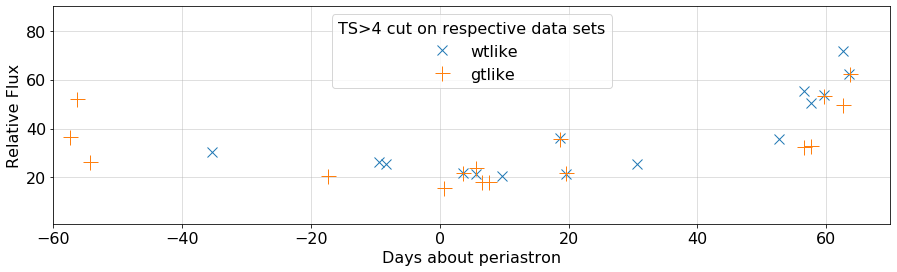

In [ ]:
%nbdev_collapse_input
tdf.loc[:,'wt_ts']= mdf.ts.values
tdf.loc[:,'wt_flux']=mdf.flux.values
tdf.loc[:,'wt_errors'] = mdf.errors.values

pa = bba; tzero = pa.date_info().MJD[3]
fig, ax = plt.subplots(figsize=(15,4))
mcut=mdf.ts.values>4
tcut=tdf.TS.values>4
ax.plot((mdf.t-tzero)[mcut], mdf.flux[mcut], 'x',ms=10, label='wtlike')
ax.plot((tdf.t-tzero)[tcut], tdf.flux[tcut], '+', ms=15, label='gtlike')
ax.set(yscale='linear', ylim=(1,90), xlim=(-60, 70), xlabel='Days about periastron', 
       ylabel='Relative Flux');
ax.legend(loc='upper center', title='TS>4 cut on respective data sets')
ax.grid(alpha=0.5);